In [1]:
%matplotlib inline
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt

from geom import make_tx_rx_trajectory, plot_radar_trajectory_and_object
from terrain_sim import TerrainSimulator
from sar_sim import SARSimulator
from bp_gpu import BackprojectionGPU
# from rcs_weight import make_W_of_theta  # 필요 시
# import ipywidgets as widgets
# display(widgets.IntSlider())

def hann_window(n):
    return 0.5 - 0.5 * np.cos(2*np.pi*np.arange(n) / (n-1))

def range_compress_from_freq(s_freq, apply_window=True):
    x = s_freq.copy()
    if apply_window:
        w = hann_window(x.shape[1])
        x *= w[None, :]
    rc = np.fft.ifft(np.fft.ifftshift(x, axes=1), axis=1)
    # rc = np.fft.ifft(x, axis=1)
    return rc

def db10(x, eps=1e-30):
    return 10.0 * np.log10(np.maximum(x, eps))


In [2]:
# 1) Terrain 생성 + roughness map
terrain = TerrainSimulator(xlim=(-50, 50), ylim=(-50, 50), nx=251, ny=251, kind="hill")
terrain_mesh = terrain.build()

In [3]:
# 2) Object 로드 + terrain 위 배치
stl_path = "F16.stl"
obj_raw = pv.read(stl_path).triangulate()
# 성능 필요 시: obj_raw = obj_raw.decimate(0.7)

sar = SARSimulator(
    f0=100e9, bandwidth=800e6, n_freq=432,
    roughness_obj=0.04,
    k_spec_obj=3.0, k_diff_obj=0.10,
    k_spec_ter=0.02, k_diff_ter=0.05,   # terrain을 더 diffuse하게 -> clutter 강화
    chunk_facets=50000,
    use_cupy=True
)

obj_mesh = sar.place_object_on_terrain(
    obj_mesh=obj_raw,
    height_fn=terrain.height_fn,
    xyz=(0.0, 0.0, 0.0),          # (x, y, z) 추가로 올리고 싶으면 z에 값
    rpy_deg=(90.0, 0.0, 90.0),   # roll, pitch, yaw (deg)
    rotate_about="center",
    snap_to_ground=True,
    z_offset=0.0
)
print("obj z bounds:", obj_mesh.bounds[4], obj_mesh.bounds[5])

obj z bounds: 15.0 21.91242027282715


In [4]:
# 3) scene mesh merge (object hybrid shadow용)
scene_mesh = sar.merge_scene_meshes([terrain_mesh, obj_mesh])

In [5]:
# 4) facets: object / terrain 분리 추출
_, c_obj, n_obj, a_obj = sar.mesh_to_facets(obj_mesh)
_, c_ter, n_ter, a_ter, r_ter = terrain.facets_with_roughness()

print(f"object facets={len(c_obj):,}, terrain facets={len(c_ter):,}")

object facets=4,092, terrain facets=125,000


In [6]:
# (옵션) 씬 확인

plotter = pv.Plotter()
plotter.add_mesh(terrain_mesh, color="tan", opacity=0.9, show_edges=False)
plotter.add_mesh(obj_mesh, color="lightgray", show_edges=False)
plotter.add_axes()
plotter.show()

Widget(value='<iframe src="http://localhost:41765/index.html?ui=P_0x7c007ad56e60_0&reconnect=auto" class="pyvi…

In [7]:
# 5) 궤적
n_pulses = 1200
tx_traj, rx_traj = make_tx_rx_trajectory(
    n_pulses=n_pulses,
    radius=500.0, z=100.0,
    start_deg=-30.0, end_deg=30.0,
    bistatic=False
)

# (선택) W(theta)
W = None
# theta_samples = np.arange(0, 361, 1)
# rcs_dbsm = ...  # 0~360 배열
# W = make_W_of_theta(theta_samples, rcs_dbsm)

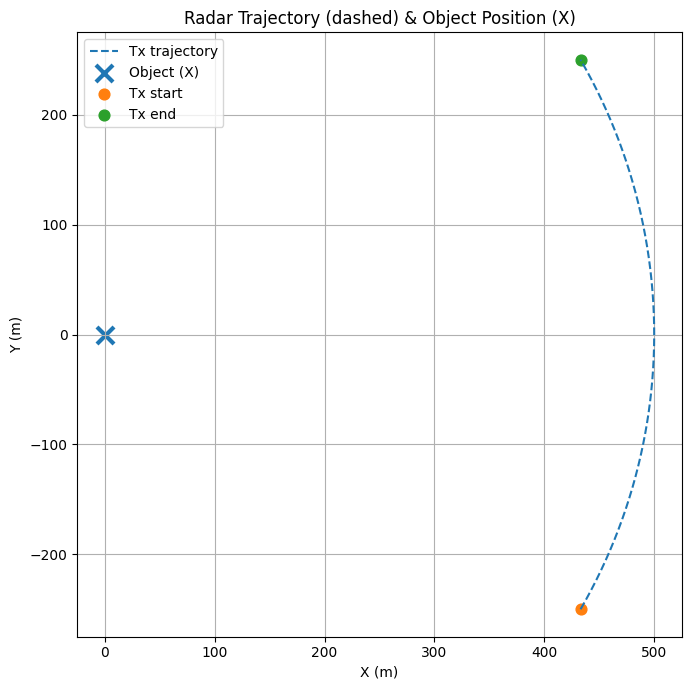

In [8]:
plot_radar_trajectory_and_object(
    object_xy=(0.0, 0.0),
    tx_traj=tx_traj, rx_traj=rx_traj,
    bistatic=False,          # True로 바꾸면 Tx/Rx 둘 다 점선 표시
)

In [9]:
# 6) raw data 취득 (object hybrid, terrain fast)
s_freq, freqs = sar.generate_phase_history_scene(
    centers_obj=c_obj, normals_obj=n_obj, areas_obj=a_obj,
    centers_ter=c_ter, normals_ter=n_ter, areas_ter=a_ter, roughness_ter=r_ter,
    # scene_mesh=scene_mesh,
    scene_mesh=obj_mesh,
    tx_traj=tx_traj, rx_traj=rx_traj,
    W_of_theta=W,
    hybrid_top_k=8000
)

[SAR] pulse 1/1200
[SAR] pulse 121/1200
[SAR] pulse 241/1200
[SAR] pulse 361/1200
[SAR] pulse 481/1200
[SAR] pulse 601/1200
[SAR] pulse 721/1200
[SAR] pulse 841/1200
[SAR] pulse 961/1200
[SAR] pulse 1081/1200


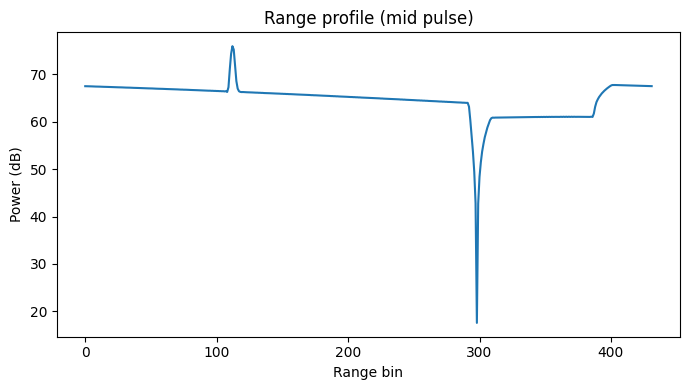

In [10]:
# 7) range compression
rc = range_compress_from_freq(s_freq, apply_window=True)
plt.figure(figsize=(7,4))
plt.plot(db10(np.abs(rc[n_pulses//2])**2))
plt.title("Range profile (mid pulse)")
plt.xlabel("Range bin")
plt.ylabel("Power (dB)")
plt.tight_layout()
plt.show()

[BP] pulse 1/1200
[BP] pulse 121/1200
[BP] pulse 241/1200
[BP] pulse 361/1200
[BP] pulse 481/1200
[BP] pulse 601/1200
[BP] pulse 721/1200
[BP] pulse 841/1200
[BP] pulse 961/1200
[BP] pulse 1081/1200


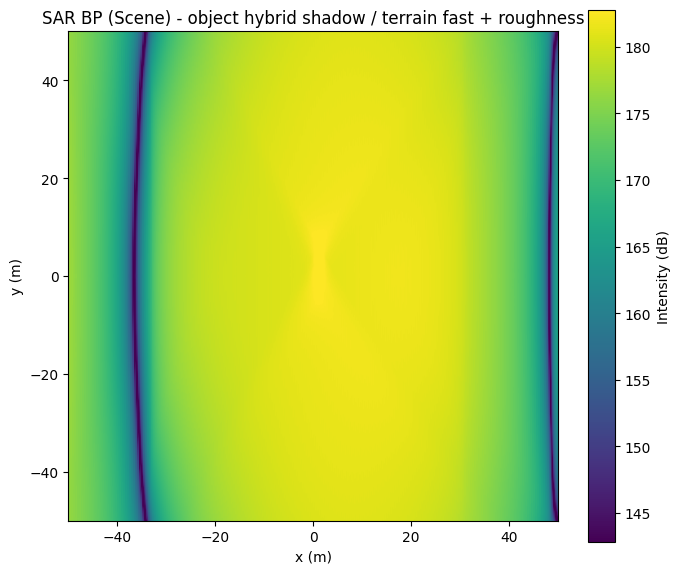

In [11]:
# 8) BP (GPU streaming)
bp = BackprojectionGPU(use_cupy=True, chunk_pixels=10000)
x_grid = np.linspace(-50, 50, 601)
y_grid = np.linspace(-50, 50, 601)

img = bp.bp_2d_streaming(
    s_freq=s_freq, freqs=freqs,
    tx_traj=tx_traj, rx_traj=rx_traj,
    x_grid=x_grid, y_grid=y_grid, z0=18.0
)
# img_mag = np.abs(img)
# img_db = db10(np.abs(img)**2)
img_db = 10*np.log10(np.abs(img)**2 + 1e-30)
vmax = np.percentile(img_db, 99.7)
plt.figure(figsize=(7,6))
plt.imshow(img_db, extent=[x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]],
            origin="lower", aspect="equal", vmin=vmax-40, vmax=vmax)
plt.colorbar(label="Intensity (dB)")
plt.title("SAR BP (Scene) - object hybrid shadow / terrain fast + roughness")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.tight_layout()
plt.show()